# Week 1 Seminar

A/B experiment analysis

In [185]:
DATA_PATH = "/tmp/log/data.json"

In [ ]:
!pip install numpy pandas scipy matplotlib

In [186]:
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

pd.set_option("display.precision", 3)

%matplotlib inline

In [187]:
experiment = "CONTEXTUAL_ARTISTS"

In [188]:
data = pd.read_json(DATA_PATH, lines=True)

In [189]:
data.head(5)

,message,timestamp,user,track,time,latency,recommendation,experiments
0,next,2023-04-15 20:23:18.503,593,6079,1.00,5.186e-03,18595.0,{'CONTEXTUAL_ARTISTS': 'C'}
1,next,2023-04-15 20:23:18.509,593,6079,1.00,3.695e-04,27260.0,{'CONTEXTUAL_ARTISTS': 'C'}
2,next,2023-04-15 20:23:18.514,593,18595,0.00,5.004e-04,44160.0,{'CONTEXTUAL_ARTISTS': 'C'}
3,next,2023-04-15 20:23:18.518,593,44160,0.00,4.072e-04,33379.0,{'CONTEXTUAL_ARTISTS': 'C'}
4,next,2023-04-15 20:23:18.520,593,27260,0.01,2.949e-04,25801.0,{'CONTEXTUAL_ARTISTS': 'C'}


In [190]:
data.experiments.value_counts()

experiments
{'CONTEXTUAL_ARTISTS': 'CONTEXTUAL_ARTISTS'}    20147
{'CONTEXTUAL_ARTISTS': 'CONTEXTUAL_BASIC'}      18074
{'CONTEXTUAL_ARTISTS': 'INDEXED'}               16011
{'CONTEXTUAL_ARTISTS': 'C'}                     15030
Name: count, dtype: int64

In [191]:
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

## Visualize sessions

In [192]:
Session = namedtuple("Session", ["timestamp", "tracks", "time", "latency"])

def sessionize(user_data):
    sessions = []
    session = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if session is None:
            session = Session(row["timestamp"], 0, 0, 0)
        
        session = session._replace(
            tracks = session.tracks + 1, 
            time = session.time + row["time"],
            latency = session.latency + row["latency"] * 1000,
        )
        
        if row["message"] == "last":
            sessions.append(session._asdict())
            session = None
    return sessions

In [193]:
sessions = (
    data
    .groupby(["user", "treatment"])
    .apply(sessionize)
    .explode()
    .apply(pd.Series)
)

In [194]:
sessions

timestamp  tracks   time  latency
user treatment                                                         
0    INDEXED            2023-04-15 20:23:50.113       7   2.43    2.356
3    CONTEXTUAL_BASIC   2023-04-15 20:23:28.781       8   2.60    1.901
     CONTEXTUAL_BASIC   2023-04-15 20:23:28.845       6   2.67    1.432
8    INDEXED            2023-04-15 20:23:19.006      15   7.82    4.068
     INDEXED            2023-04-15 20:23:19.053       4   1.35    1.044
...                                         ...     ...    ...      ...
9987 CONTEXTUAL_BASIC   2023-04-15 20:23:20.794      40  34.18   10.465
9988 CONTEXTUAL_ARTISTS 2023-04-15 20:23:38.172       6   1.00    1.547
9994 CONTEXTUAL_BASIC   2023-04-15 20:23:42.797       9   2.22    1.993
     CONTEXTUAL_BASIC   2023-04-15 20:23:43.250       7   1.79    1.690
9997 INDEXED            2023-04-15 20:23:30.808       8   2.02    1.882

[8000 rows x 4 columns]

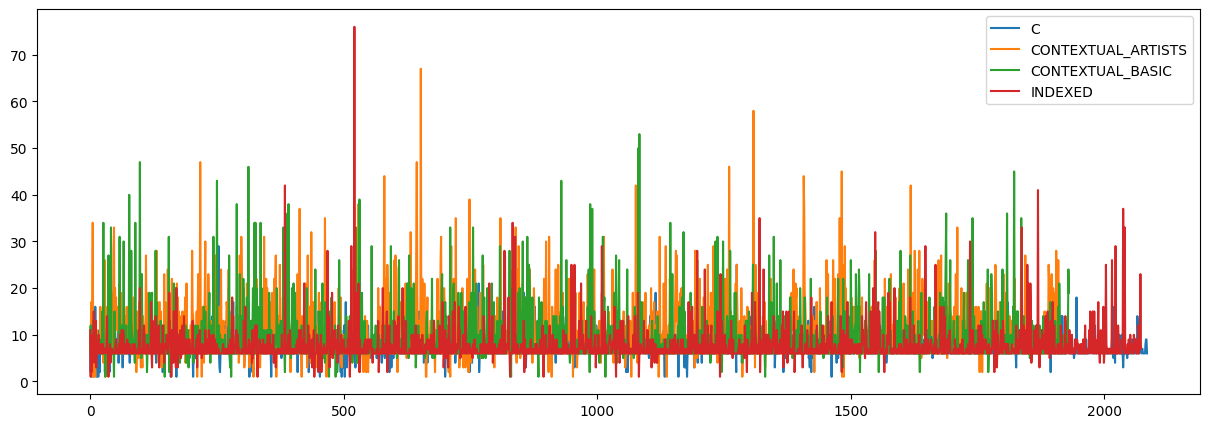

In [195]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["tracks"], label=treatment)
ax.legend()
pass

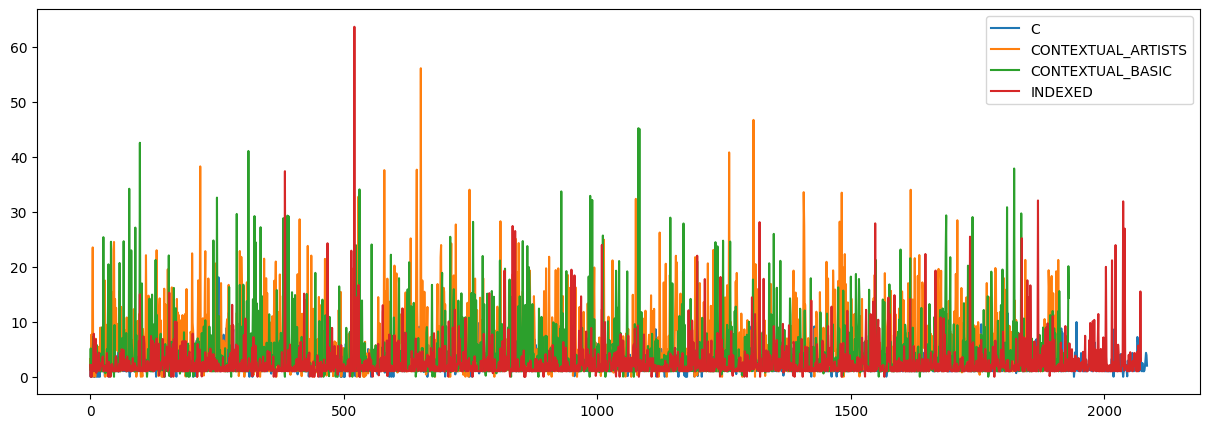

In [196]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["time"], label=treatment)
ax.legend()
pass

## Analyze the experiment

In [197]:
user_level_data = (
  sessions
    .reset_index()
    .groupby(["user", "treatment"])
    .agg(
        {
            "timestamp": "count",
            "tracks": "sum",
            "time": "sum",
            "latency": "sum"
        }
    )
)

user_level_data["sessions"] = user_level_data["timestamp"]
user_level_data["mean_request_latency"] = user_level_data["latency"] / user_level_data["tracks"]
user_level_data["mean_tracks_per_session"] = user_level_data["tracks"] / user_level_data["sessions"]
user_level_data["mean_time_per_session"] = user_level_data["time"] / user_level_data["sessions"]

metrics = [
    "time", 
    "sessions", 
    "mean_request_latency", 
    "mean_tracks_per_session", 
    "mean_time_per_session"
]

user_level_metrics = user_level_data[metrics].copy().reset_index()

In [198]:
treatment_level_metrics = (
    user_level_metrics
    .groupby("treatment")[metrics]
    .agg(["count", "mean", "var"])
)

In [199]:
def dof(n_0, n_1, s2_0, s2_1):
    numerator = (s2_0 / n_0 + s2_1 / n_1) * (s2_0 / n_0 + s2_1 / n_1)
    denominator = s2_0 * s2_0 / n_0 / n_0 / (n_0 - 1) + s2_1 * s2_1 / n_1 / n_1 / (n_1 - 1)
    return numerator / denominator


def ci(n_0, n_1, s2_0, s2_1, alpha=0.05):
    return ss.t.ppf(1 - alpha/2, dof(n_0, n_1, s2_0, s2_1)) * np.sqrt(s2_0 / n_0 + s2_1 / n_1)


effects = []

control = [data for treatment, data in treatment_level_metrics.iterrows() if treatment == "C"][0]

for treatment, row in treatment_level_metrics.iterrows():
    if treatment == "C":
        continue
    
    for metric in metrics:
        control_mean = control[metric]["mean"]
        treatment_mean = row[metric]["mean"]
        
        effect = treatment_mean - control_mean
        conf_int = ci(
            control[metric]["count"],
            row[metric]["count"],
            control[metric]["var"],
            row[metric]["var"],
        )
        effects.append({
            "treatment": treatment,
            "metric": metric,
            "control_mean": control_mean,
            "treatment_mean": treatment_mean,
            "effect": effect / control_mean * 100,
            "lower": (effect - conf_int) / control_mean * 100,
            "upper": (effect + conf_int) / control_mean * 100,
            "significant": (effect + conf_int) * (effect - conf_int) > 0
        })

In [200]:
def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
10,INDEXED,time,25.369855,39.012752,11.726958,4.571541,5.731334,True
5,CONTEXTUAL_BASIC,time,83.490471,99.849183,67.131758,4.571541,8.388342,True
0,CONTEXTUAL_ARTISTS,time,148.916305,168.811592,129.021019,4.571541,11.379310,True
11,INDEXED,sessions,1.854386,7.717374,-4.008602,2.072565,2.110998,False
6,CONTEXTUAL_BASIC,sessions,-6.923484,-1.106990,-12.739979,2.072565,1.929071,True
1,CONTEXTUAL_ARTISTS,sessions,-0.641590,5.282606,-6.565786,2.072565,2.059267,False
13,INDEXED,mean_tracks_per_session,7.396898,10.589406,4.204390,7.152495,7.681558,True
8,CONTEXTUAL_BASIC,mean_tracks_per_session,32.823117,37.652480,27.993755,7.152495,9.500167,True
3,CONTEXTUAL_ARTISTS,mean_tracks_per_session,45.127251,49.712567,40.541935,7.152495,10.380220,True
14,INDEXED,mean_time_per_session,23.434082,33.588202,13.279963,2.162093,2.668759,True
